In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
data = load_breast_cancer()


In [7]:
X = data.data
y = data.target

In [8]:
df =pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

In [9]:
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("Target Classes:", data.target_names)

Features (X) shape: (569, 30)
Target (y) shape: (569,)
Target Classes: ['malignant' 'benign']


In [10]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**Starting EDA**

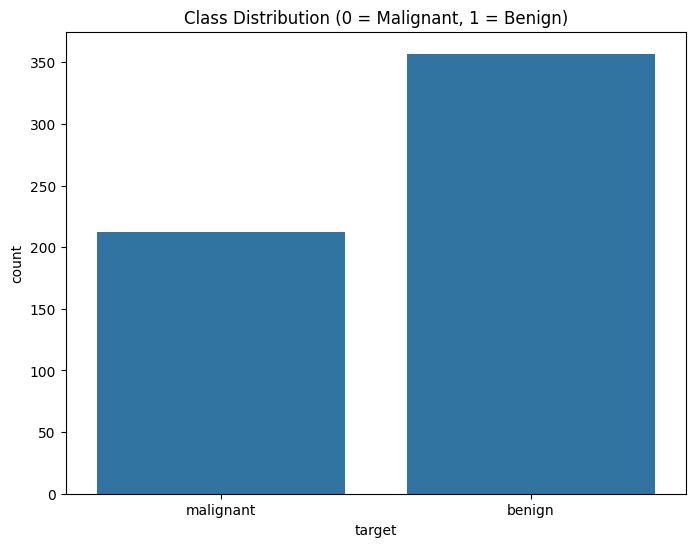

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Class Distribution (0 = Malignant, 1 = Benign)')
plt.xticks(ticks=[0, 1], labels=data.target_names)
plt.show()

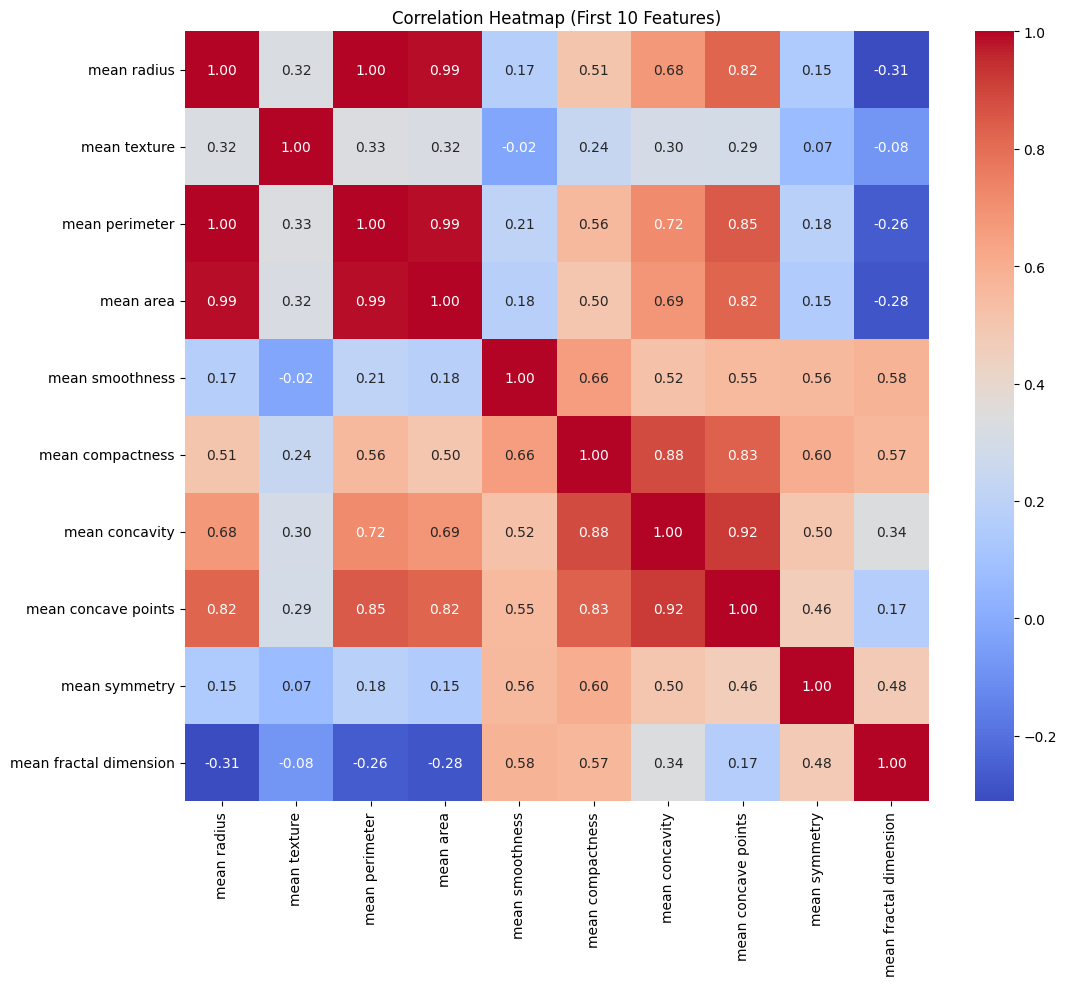

In [13]:
corr_matrix = df.iloc[:, :10].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Correlation Heatmap (First 10 Features)')
plt.show()

***--- DATA PREPARATION ---***

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 455 samples
Testing set size: 114 samples


****Random Forest****

In [15]:
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_baseline.fit(X_train, y_train)
y_pred_rf = rf_baseline.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_rf)
print(f"Baseline RF Accuracy: {acc_base * 100:.2f}%")

Baseline RF Accuracy: 96.49%


# Model Optimization with Pipeline & GridSearchCV

In [16]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42))
    ]
)

In [21]:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [1, 0.1, 0.01] # 'gamma' only applies to 'rbf'
}

In [22]:
grid_search = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1,verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__gamma': [1, 0.1, 0.01],
                         'svm__kernel': ['linear', 'rbf']},
             verbose=2)

# Evaluating the Optimized Model

In [23]:
grid_search.best_params_

{'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}

In [26]:
print(f"Best cross_validation accuracy: {grid_search.best_score_ * 100:.2f}%")

Best cross_validation accuracy: 97.36%


In [27]:
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

In [28]:
acc_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Final Test Set Accuracy SVM: {acc_tuned * 100:.2f}%")

Final Test Set Accuracy SVM: 98.25%


In [29]:
classification_report(y_test, y_pred_tuned, target_names = data.target_names)

'              precision    recall  f1-score   support\n\n   malignant       1.00      0.95      0.98        43\n      benign       0.97      1.00      0.99        71\n\n    accuracy                           0.98       114\n   macro avg       0.99      0.98      0.98       114\nweighted avg       0.98      0.98      0.98       114\n'

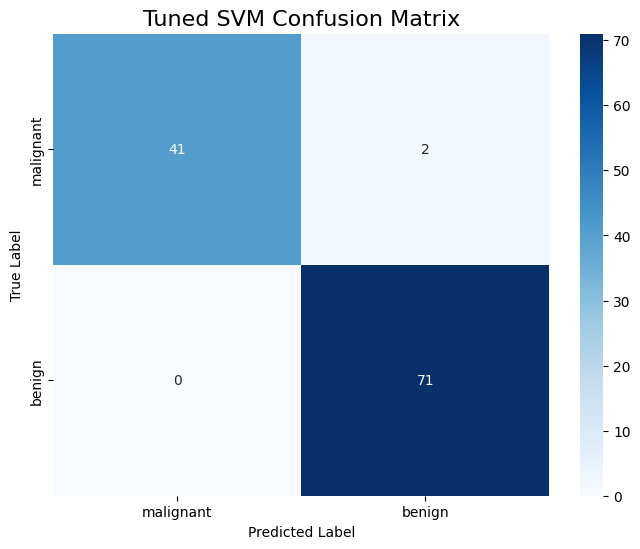

In [32]:
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True,fmt='d',cmap='Blues', 
            xticklabels=data.target_names,
            yticklabels=data.target_names
           )
plt.title('Tuned SVM Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()